In [1]:
import os
import pandas as pd
import os.path as osp
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

## Load files

In [2]:
os.getcwd()

'D:\\Project- Electro\\social_behavior_electro\\data_organization\\python'

In [3]:
folder_path = osp.join('..','..','analysis')
path_to_aversive = osp.join(folder_path,
                            'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_aversive.xlsx')
path_to_affiliative = osp.join(folder_path,
                               'Population analysis results for LFP Coherence - Encounter-PreEncounter_4-12_30-80_affiliative.xlsx')
path_to_common_areas = osp.join(folder_path, 'common_area_pairs_w5_sessions.xlsx')



In [4]:
df_aff = pd.read_excel(path_to_affiliative,None)
df_avv = pd.read_excel(path_to_aversive,None)

df_files_avv = pd.read_excel(path_to_aversive,'Uploaded files', header=None)
df_files_aff = pd.read_excel(path_to_affiliative,'Uploaded files', header=None)

df_areas = pd.read_excel(path_to_common_areas)


## Get info

### Number of sessions in each state

In [5]:
def get_number_of_sessions(df):
    max_len = 0
    for df_t in df.values():
        # find the max length
        max_len = max(max_len, len(df_t))
    return max_len

In [6]:
n_sssions_aff = get_number_of_sessions(df=df_aff)
n_sssions_avv = get_number_of_sessions(df=df_avv)

In [7]:
# I had to hard code this part since the names on the tables are different
important_pairs_in_data = [
    ('Area 111 MeA', 'Area 13 CeA'),
    ('Area 111 MeA', 'Area 112 BMA'),
    ('Area 111 MeA', 'Area 14 AA/ACO/VEN'),
    ('Area 111 MeA', 'Area 16 EA'),
    ('Area 111 MeA', 'Area 12 STIA'),
    ('Area 2 MePV', 'Area 112 BMA'),
    ('Area 13 CeA', 'Area 12 STIA'),
    ('Area 112 BMA', 'Area 14 AA/ACO/VEN')
]


## Get important pairs directly from the tables

In [8]:
# Each pair must appear in at least 5 session in each state
'''
- loop over all possible pairs and count the number of session for each pair
- keep only the pairs that were mesured only match conditions
'''
def get_area_names(df):
    all_areas = [area.replace('During','').replace('Before','').replace('First','').replace('Second','') for area in list(df.keys())]
    all_areas = set(all_areas)
    all_areas = all_areas - set(['NormMinus','Uploaded files'])
    return all_areas
areas_aff = get_area_names(df_aff)
areas_avv = get_area_names(df_avv)

common_areas = areas_aff.intersection(areas_avv)

def search_tuple_in_array_no_order(t, t_array):
    t_array = list(t_array)
    for t2 in t_array:
        if set(t) == set(t2):
            return True
        return False
    

def get_n_session_for_each_pair(df):
    MIN_N_SESSION = 5
    ret = dict()
    for area_sheet, data in df.items():
        # Only look at "First" (frequency range)
        if 'Norm' in area_sheet or 'Uploaded files' in area_sheet or 'Second' in area_sheet:
            continue
        area_name = area_sheet.replace('During','').replace('Before','').replace('First','')
        n_sessions = data.count()
        valid_session_ind = n_sessions>=MIN_N_SESSION
        valid_area_pairs = list(n_sessions[valid_session_ind].index)
        
        for area2 in valid_area_pairs:
            if search_tuple_in_array_no_order((area_name, area2), ret.keys()):
                continue
            ret[tuple(sorted([area_name, area2]))] = n_sessions[area2]
         
    return ret



In [9]:
valid_avv = get_n_session_for_each_pair(df = df_avv)
valid_aff = get_n_session_for_each_pair(df = df_aff)


In [10]:
# combine two dicts, keep only common keys
# folter non common pairs
common_pairs = set(valid_avv.keys()).intersection(set(valid_aff.keys())) # this is ok since the tuples are sorted
# convert to dataframe
dict_sum = {}
dict_sum['affiliative'] = {p:valid_aff[p] for p in common_pairs}
dict_sum['aversive'] = {p:valid_avv[p] for p in common_pairs}

In [11]:
df_counts = pd.DataFrame.from_dict(dict_sum)
df_counts

affiliative  aversive
BMA MeD            15         7
CeA MeD             6        12
    STIA            5        10
MeD STIA            5        11
AA  BMA             5         6
    MeD            10        14
EA  MeD             8        11
BMA MePV            9         6

## Extract means and std

In [12]:
def fix_file_paths(df_files):
    
    

    df_files = df_files.rename(columns={df_files.columns[0]:'timestamps', df_files.columns[0]:'lfp', })
    
    return df_files
    
def extreact_vals(df, pair, df_file_paths, range_of_freq='First', call_num=0):

    all_sheet_names = df.keys()
    sheet_name = [n for n in all_sheet_names if range_of_freq in n and pair[0] in n][0]
    vals = df[sheet_name][pair[1]].values
    if len(vals)>0:
        non_nan_vals = ~np.isnan(vals)
        vals = vals[np.where(non_nan_vals)]
        try:
            filenames = df_file_paths.iloc[np.where(non_nan_vals)]
        except:
            print('Printing data of df files')
            print(np.where(non_nan_vals))
            print(df_file_paths['lfp'])
            print(range_of_freq)
            return 


    else:
        vals = []
        filenames = []

    if len(vals)==0 and call_num==0:
        vals, filenames = extreact_vals(df, (pair[1],pair[0]),df_file_paths, range_of_freq,call_num=1)
        
    return vals, filenames


In [13]:
df_file_paths_aff = fix_file_paths(df_files_aff)
df_file_paths_avv = fix_file_paths(df_files_avv)

# vals_aff, filenames_aff = extreact_vals(df=df_avv, df_file_paths=df_file_paths_aff, pair=('AA', 'BMA'), range_of_freq='First', call_num=0)

In [14]:
# df_file_paths_aff

In [15]:

# columns names: pair, sosicability, coherence, filenaem 
# first range - 4-12 Hz
# second range - 30-80 Hz
sociability = {'affiliative':df_file_paths_aff,'aversive':df_file_paths_avv}
df_sociability = {'affiliative':df_aff,'aversive':df_avv}
# sociability = {'affiliative':df_file_paths_aff}
# df_sociability = {'affiliative':df_aff}


frequency_bands = {'First':'4-12','Second':'30-80'}

df_sum_list = []
for pair in common_pairs:
    for social in sociability.keys():
        for freq in frequency_bands.keys():

#             try:
            vals, filenames = extreact_vals(
                df=df_sociability[social],
                pair=pair,
                df_file_paths=sociability[social],
                range_of_freq=freq,
                call_num=0)
    
#             except:
# #                 print(social)
# #                 print(sociability[social])
# #                 print(pair)
# #                 print(df_sociability[social])
# #                 print(social, pair, freq)                
#                 break
                
            temp_dict ={'area1': pair[0],
                        'area2': pair[1],
                        'sociability': social, 
                        'frequency_band': frequency_bands[freq],
                        'coherence': vals}
            temp_df = pd.DataFrame.from_dict(temp_dict)
#             temp_df.columns = temp_df.columns[::-1]
            df_sum_list.append(temp_df)
df_sum = pd.concat(df_sum_list)

df_sum_list= []
for pair in common_pairs:
    for social in sociability:
        for freq in frequency_bands.keys():
            
            vals, filenames = extreact_vals(
                df=df_sociability[social], df_file_paths=sociability[social], pair=pair, range_of_freq=freq, call_num=0)
            temp_dict ={pair: {'sociability': social, 
                               'frequency_band': frequency_bands[freq],
                               'coherence': vals}}
            temp_df = pd.DataFrame.from_dict(temp_dict).transpose()
#             temp_df.columns = temp_df.columns[::-1]
            df_sum_list.append(temp_df)
df_sum2 = pd.concat(df_sum_list)
df_sum2 = df_sum2[df_sum2.columns[::-1]]
df_sum2['mean'] = df_sum2['coherence'].apply(lambda x: np.mean(x))
df_sum2['std'] = df_sum2['coherence'].apply(lambda x: np.std(x))
df_sum2 = df_sum2.reset_index()
df_sum2 = df_sum2.rename(columns={'level_0':'area1', 'level_1': 'area2'})
df_sum2.columns

Index(['area1', 'area2', 'sociability', 'frequency_band', 'coherence', 'mean',
       'std'],
      dtype='object')

In [16]:
df_sum

,area1,area2,sociability,frequency_band,coherence
0,BMA,MeD,affiliative,4-12,0.008472
1,BMA,MeD,affiliative,4-12,0.044691
2,BMA,MeD,affiliative,4-12,0.045925
3,BMA,MeD,affiliative,4-12,0.021211
4,BMA,MeD,affiliative,4-12,-0.290696
...,...,...,...,...,...
1,BMA,MePV,aversive,30-80,-0.241164
2,BMA,MePV,aversive,30-80,0.019826
3,BMA,MePV,aversive,30-80,-0.075039
4,BMA,MePV,aversive,30-80,-0.062391


In [17]:
area_pairs = df_sum2[['area1','area2']].values
area_pairs = [(a,b) for a,b in area_pairs]
df_sum2['area_pairs'] = area_pairs
df_sum2

,area1,area2,sociability,frequency_band,coherence,mean,std,area_pairs
0,BMA,MeD,affiliative,4-12,"[0.008472052774922424, 0.044690768421410815, 0...",-0.068920,0.167978,"(BMA, MeD)"
1,BMA,MeD,affiliative,30-80,"[0.001575109155455231, 0.006133381131682354, 0...",-0.030763,0.111972,"(BMA, MeD)"
2,BMA,MeD,aversive,4-12,"[-0.005398350721005377, -0.015387869256428051,...",-0.048016,0.083483,"(BMA, MeD)"
3,BMA,MeD,aversive,30-80,"[0.01109051352210949, -0.008887633457759838, -...",-0.039394,0.098641,"(BMA, MeD)"
4,CeA,MeD,affiliative,4-12,"[-0.2783367927282807, -0.1969289180747496, -0....",-0.124849,0.089331,"(CeA, MeD)"
5,CeA,MeD,affiliative,30-80,"[-0.14540752224689185, -0.22748645803561543, -...",-0.074453,0.086853,"(CeA, MeD)"
6,CeA,MeD,aversive,4-12,"[0.09063561825729101, -0.11228825714121662, -0...",-0.033643,0.061981,"(CeA, MeD)"
7,CeA,MeD,aversive,30-80,"[0.09663456862069986, -0.05443674361551626, -0...",0.003191,0.033525,"(CeA, MeD)"
8,CeA,STIA,affiliative,4-12,"[-0.07394397202218228, -0.21375494174748544, -...",-0.090843,0.065829,"(CeA, STIA)"
9,CeA,STIA,affiliative,30-80,"[-0.023188567811842642, -0.10943189524334396, ...",-0.046006,0.040467,"(CeA, STIA)"


,area1,area2,mean
0,MeD,STIA,0.013921
4,BMA,MeD,-0.068920
8,CeA,MeD,-0.124849
12,AA,BMA,-0.075196
16,CeA,STIA,-0.090843
20,EA,MeD,-0.098501
24,BMA,MePV,-0.032533
28,AA,MeD,-0.128436


## Draw a network graph

In [18]:
import networkx as nx
from scipy import stats



In [19]:
mean_co = df_sum2['mean'].values
z_means = stats.zscore(mean_co)
df_sum2['zscore_mean'] = z_means

In [132]:
def plot_network(df_graph, pos = None, th=None):
    G = nx.Graph()

    area1_list = df_graph['area1'].values
    area2_list = df_graph['area2'].values
#     vals = df_graph['zscore_mean'].values
    vals = df_graph['mean'].values
    vals = np.round(vals,3)
    if th is None:
        th = np.mean(vals)
    
    # z_score_list_scale = (z_score_list-np.min(z_score_list))/(np.max(z_score_list)-np.min(z_score_list))
    # z_score_list_scale = np.round(z_score_list_scale,3)


    [G.add_edge(a, b, weight=c) for a,b,c in zip(area1_list, area2_list, vals)]


    elarge = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] > th]
    esmall = [(u, v) for (u, v, d) in G.edges(data=True) if d["weight"] <= th]

    
    if pos is None:
#         pos = nx.spring_layout(G, seed=7)  # positions for all nodes - seed for reproducibility
        pos = nx.planar_layout(G)  # positions for all nodes - seed for reproducibility


#     plt.figure(figsize=(5,10))

    # nodes
    nx.draw_networkx_nodes(G, pos, node_size=700)



    # edges
    nx.draw_networkx_edges(G, pos, edgelist=elarge, width=6)
    nx.draw_networkx_edges(
        G, pos, edgelist=esmall, width=6, alpha=0.5, edge_color="b", style="dashed"
    )

    # node labels
    nx.draw_networkx_labels(G, pos, font_size=20, font_family="sans-serif")
    # edge weight labels
    edge_labels = nx.get_edge_attributes(G, "weight")
    nx.draw_networkx_edge_labels(G, pos, edge_labels)


    ax = plt.gca()
    ax.margins(0.08)
    plt.axis("off")
    plt.tight_layout()
    plt.show()
    return pos, ax

In [133]:
df_sum_aff_theta = df_sum2.loc[(df_sum2['sociability']=='affiliative')&(df_sum2['frequency_band']=='4-12')][['area1','area2','mean','zscore_mean']]
df_sum_avv_theta = df_sum2.loc[(df_sum2['sociability']=='aversive')&(df_sum2['frequency_band']=='4-12')][['area1','area2','mean','zscore_mean']]


In [134]:
df_sum_avv_theta

,area1,area2,mean,zscore_mean
2,BMA,MeD,-0.048016,-0.122713
6,CeA,MeD,-0.033643,0.257902
10,CeA,STIA,-0.064484,-0.558795
14,MeD,STIA,-0.007769,0.943059
18,AA,BMA,-0.025982,0.460758
22,AA,MeD,-0.014978,0.752159
26,EA,MeD,-0.084051,-1.076916
30,BMA,MePV,-0.086248,-1.135109


In [135]:
df_sum_aff_theta

,area1,area2,mean,zscore_mean
0,BMA,MeD,-0.068920,-0.676264
4,CeA,MeD,-0.124849,-2.157267
8,CeA,STIA,-0.090843,-1.256775
12,MeD,STIA,0.013921,1.517404
16,AA,BMA,-0.075196,-0.842436
20,AA,MeD,-0.128436,-2.252260
24,EA,MeD,-0.098501,-1.459579
28,BMA,MePV,-0.032533,0.287283


In [136]:
vals_aff = df_sum_aff_theta['mean'].values
vals_avv = df_sum_avv_theta['mean'].values
mean_all = np.array([vals_aff,vals_avv]).mean()
mean_all

-0.06065797797122068

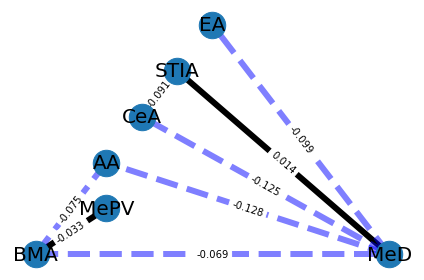

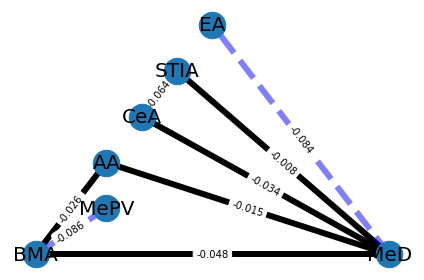

In [137]:

pos, ax1 = plot_network(df_graph=df_sum_aff_theta, th=mean_all)

_, ax2 = plot_network(df_graph=df_sum_avv_theta, pos=pos, th=mean_all)

# fig, (ax_left, ax_right) = plt.subplots(1, 2)

# # Move the original axes to the new figure
# fig.add_axes(ax1)
# fig.add_axes(ax2)
# # plotSideBySide(ax1, ax2)

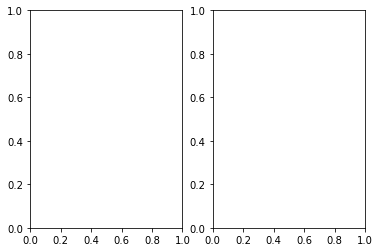

In [146]:
 fig, (ax11, ax12) = plt.subplots(1,2)

In [148]:
ax1.set_figure(fig)

RuntimeError: Can not put single artist in more than one figure